In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,10)

---

In [3]:
def api_url(indikator_: int) -> str:
    """ Return URL for endpoint at specified indikator id """
    url = 'http://193.246.68.117:8080/gp/GP?type=EXPORT&indikatoren={}&raumtyp=1&text=yes'
    return url.format(indikator_)

In [4]:
def api_get_dataframe(indikator_: int) -> (pd.DataFrame, pd.DataFrame):
    """ Generate pd.DataFrames for 'RAUM' and 'INDIKATOR' keys using indikator id """
    json_ = requests.get(api_url(indikator_)).json()
    return (pd.io.json.json_normalize(json_['RAUM']),
            pd.io.json.json_normalize(json_['INDIKATOR']))

In [5]:
def gemeinde_dataframe(raum_df_: pd.DataFrame) -> pd.DataFrame:
    """ Generate pd.DataFrame using pd.DataFrame of 'RAUM' data - index is gemeinde name """
    raum_dates = raum_df_.drop(['BFS', 'DATEN_VORHANDEN', 'ALLE_JAHRE', 'RAUMEINHEIT_ID', 'RAUMEINHEIT_NAME'], axis=1).astype(float)
    raum_dates.columns = sorted(raum_df_.ALLE_JAHRE[0])
    raum_dates.index = raum_df_.RAUMEINHEIT_NAME
    return raum_dates

In [6]:
def gemeinde_by_date(raum_df_: pd.DataFrame, gemeinde: str) -> pd.DataFrame:
    """ Generate single column pd.DataFrame using pd.DataFrame of 'RAUM' data - index is date """
    df = raum_df_[raum_df_.RAUMEINHEIT_NAME == gemeinde]
    ix = df.index[0]
    years = sorted(df.ALLE_JAHRE.values[0])
    df = df.drop(['BFS', 'DATEN_VORHANDEN', 'ALLE_JAHRE', 'RAUMEINHEIT_ID','RAUMEINHEIT_NAME'], axis=1).astype(float)
    df.columns = years
    return pd.DataFrame(df.stack()[ix], columns=[gemeinde])

In [7]:
def gemeinde_df_by_indikator(indikator_: int) -> pd.DataFrame:
    return gemeinde_dataframe(api_get_dataframe(indikator_)[0])

---

In [8]:
bevolkerung, _ = api_get_dataframe(133)

In [9]:
gemeinde_dataframe(bevolkerung).head()

,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
RAUMEINHEIT_NAME,,,,,,,,,,,,,,,,,,,,,
Adlikon,400.0,400.0,389.0,388.0,390.0,394.0,398.0,394.0,380.0,398.0,...,571.0,579.0,577.0,579.0,562.0,573.0,609.0,662.0,662.0,655.0
Adliswil,10422.0,11349.0,11760.0,12450.0,12898.0,13723.0,14738.0,15362.0,15920.0,15901.0,...,15918.0,16051.0,16488.0,17472.0,17997.0,18216.0,18381.0,18551.0,18651.0,18731.0
Aesch ZH,340.0,340.0,349.0,362.0,401.0,422.0,436.0,459.0,472.0,469.0,...,987.0,1001.0,1034.0,1083.0,1158.0,1183.0,1182.0,1198.0,1269.0,1341.0
Aeugst a.A.,710.0,720.0,705.0,695.0,745.0,704.0,678.0,726.0,700.0,729.0,...,1700.0,1737.0,1822.0,1911.0,1959.0,1970.0,1952.0,1986.0,1969.0,1934.0
Affoltern a.A.,5370.0,5753.0,6001.0,6303.0,6539.0,6660.0,6945.0,6997.0,7363.0,7325.0,...,10631.0,10705.0,11063.0,11140.0,11265.0,11342.0,11540.0,11695.0,11868.0,12080.0


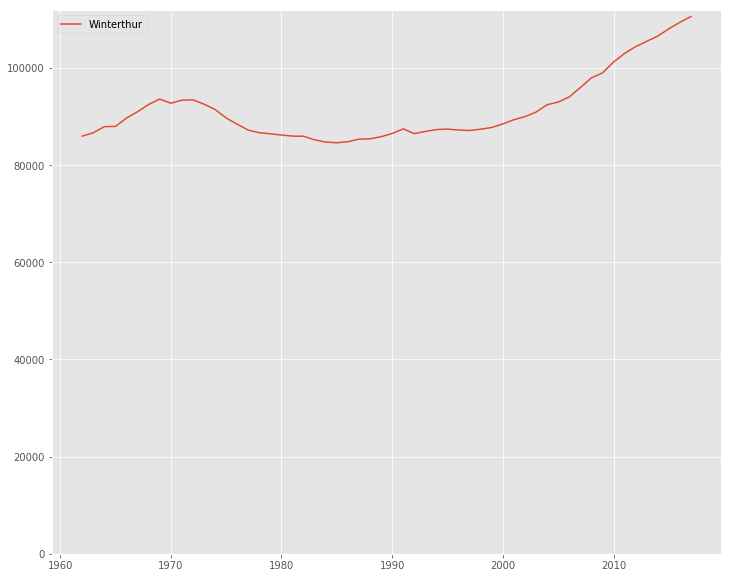

In [10]:
gemeinde_by_date(bevolkerung, 'Winterthur').plot()
plt.ylim((0, max(plt.ylim(0))))
None

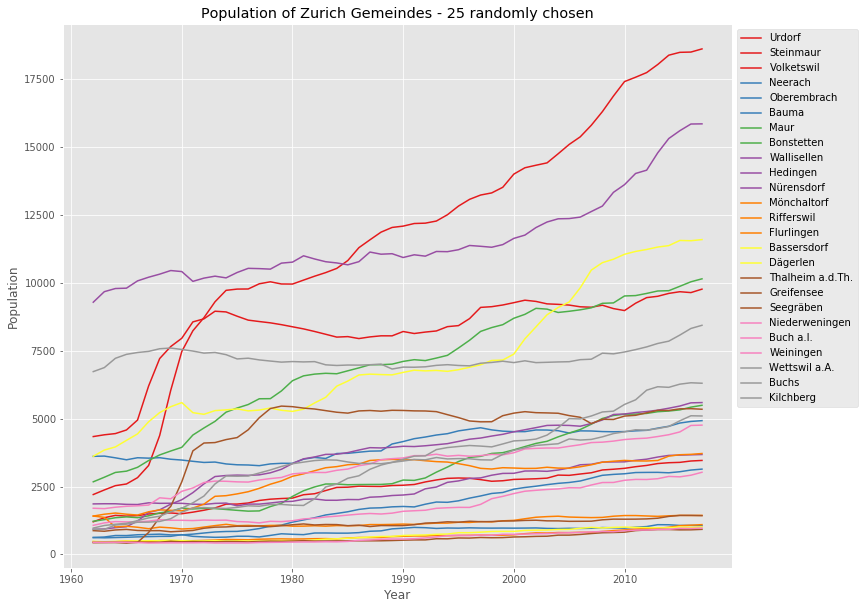

In [216]:
n=25
gemeinde_df_by_indikator(133).sample(n).T.plot(cmap=plt.cm.Set1)
plt.title("Population of Zurich Gemeindes - {} randomly chosen".format(n))
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend(bbox_to_anchor=(1,1))
None

In [11]:
bevolkerungzunahme, _ = api_get_dataframe(200)

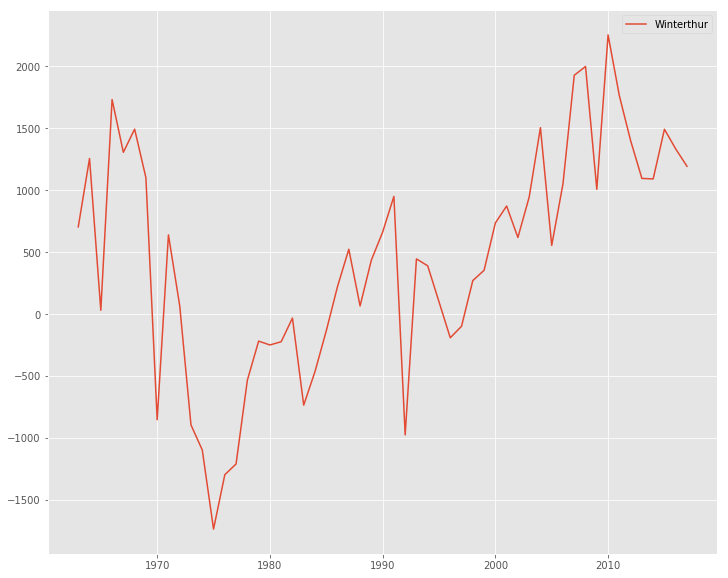

In [12]:
gemeinde_by_date(bevolkerungzunahme, 'Winterthur').plot()

In [13]:
auslanderanteil = gemeinde_df_by_indikator(205)

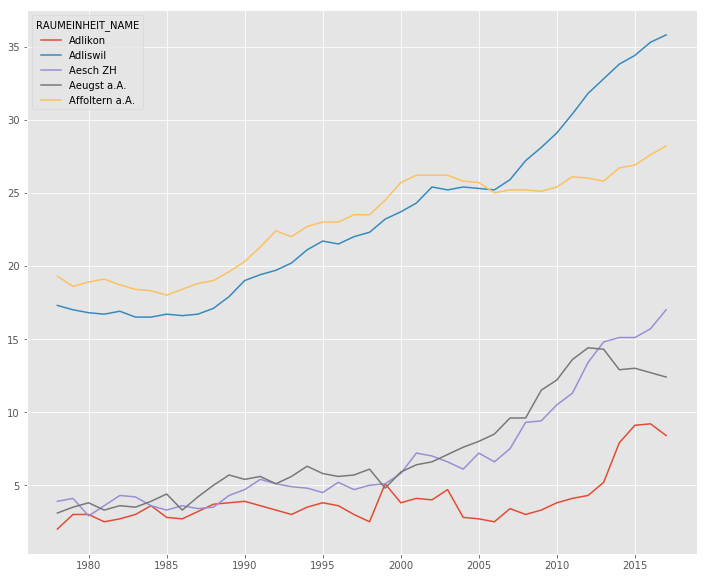

In [14]:
auslanderanteil.head().T.plot()

---

## Wikidata Pywikibot

In [15]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(("\\".join(nb_dir.split('\\')[:-3])) + "\\pywikibot\\core")
    
print(sys.path[-1])

C:\Users\Jeremy\Documents\Programming\wikidata
C:\Users\Jeremy\pywikibot\core


In [26]:
import pywikibot as pw

In [20]:
import inspect

In [135]:
def get_wikidata_item(label_):
    item = None
    site = pw.Site("en", "wikipedia")
    page = pw.Page(site, label_)
    try:
        item = pw.ItemPage.fromPage(page)
    except Exception as e:
        print("Something went wrong...")
        print(e)
        
    return item

In [167]:
def get_wikipedia_item(item_id_):
    page, item = None, None
    site = pw.Site("wikidata", "wikidata")
    repo = site.data_repository()

    try:
        item = pw.ItemPage(repo, item_id_)
        item.get()
    except Exception as e:
        print("Something went wrong...")
        print(e)
        
    return item

In [175]:
def parse_item_property(item_, prop_):
    item_dict = item_.get()
    clm_list = None
    if 'claims' in item_dict:
        clm_dict = item_dict['claims'] # create dictionary of claims from wikidata
        if prop_ in clm_dict:
            clm_list = clm_dict[prop_] # look for population
    return clm_list

In [181]:
def iterate_item_label(label_, prop_='P31'):
    item_ = get_wikidata_item(label_)
    count = 0
    wiki = get_wikipedia_item(item_.id)
    while wiki is not None and count < 5:
        if 'en' in wiki.labels:
            print(wiki.id)
            print('The label in English is: ' + wiki.labels['en'])

        claim = parse_item_property(wiki, prop_)
        count += 1
        if claim is not None:
            target = claim[0].getTarget()
            new_wiki = get_wikipedia_item(target.id)
            wiki = new_wiki if wiki != new_wiki and new_wiki is not None else None
        else:
            break

In [177]:
iterate_item_label('Douglas Adams')

Q42
The label in English is: Douglas Adams
Q5
The label in English is: human
Q502895
The label in English is: common name


In [178]:
iterate_item_label("Fountain")

Q483453
The label in English is: fountain


In [179]:
iterate_item_label("Banana")

Q503
The label in English is: banana


In [180]:
iterate_item_label("Morocco")

Q1028
The label in English is: Morocco
Q41614
The label in English is: constitutional monarchy
Q1307214
The label in English is: form of government


---

In [190]:
canton_zurich = get_wikipedia_item("Q11943")

In [200]:
canton_zurich.data_repository

DataSite("wikidata", "wikidata")

In [191]:
for member in inspect.getmembers(canton_zurich):
    if "__" not in member[0]:
        print(member[0])

_cache_attrs
_cmpkey
_content
_cosmetic_changes_hook
_defined_by
_diff_to
_getInternals
_get_parsed_page
_isredir
_latest_cached_revision
_link
_namespace
_normalizeData
_normalizeLanguages
_pageid
_revid
_revisions
_save
addClaim
aliases
applicable_protections
aslink
autoFormat
backlinks
botMayEdit
canBeEdited
categories
change_category
claims
clear_cache
concept_uri
concept_url
content_model
contributingUsers
contributors
coordinates
data_item
data_repository
defaultsort
delete
descriptions
editAliases
editDescriptions
editEntity
editLabels
editTime
embeddedin
encoding
entity_type
exists
expand_text
extlinks
fromPage
from_entity_uri
fullVersionHistory
full_url
get
getCategoryRedirectTarget
getCreator
getDeletedRevision
getID
getLatestEditors
getMovedTarget
getOldVersion
getRedirectTarget
getReferences
getRestrictions
getSitelink
getTemplates
getVersionHistory
getVersionHistoryTable
getdbName
id
image_repository
imagelinks
interwiki
isAutoTitle
isCategory
isCategoryRedirect
isDisambig